# 准备数据

cifar2 数据集为cifar10数据集的子集，只包括两种类别的airplane和automobile。
训练集有airplane和automobile图片各5000张，测试集有airplane和automobile各1000张。
cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类
我们准备的Cifar2数据集的文件结构如下所示：

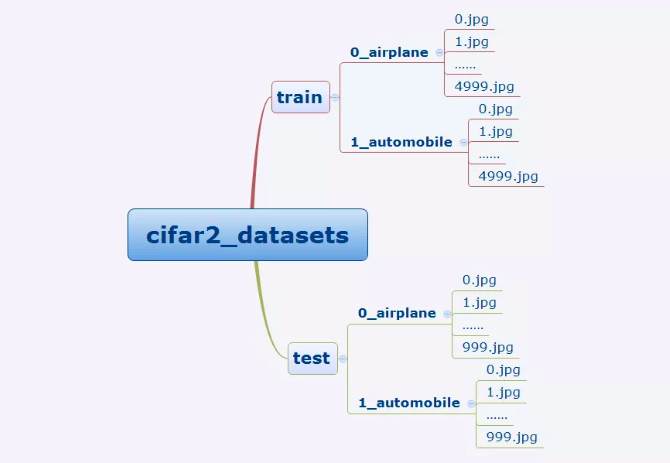

在tensorflow中准备图片数据的常用方案有两种，第一种是使用tf.keras中的ImageDataGenerator工具构建图片数据生成器。
第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道
第一种方法更为简单，参考：https://mp.weixin.qq.com/s?__biz=MzU3OTQzNTU2OA==&mid=2247484795&idx=1&sn=16947726702b87ee535aef0d6ae2db30&chksm=fd676824ca10e1321e77c5fa44339c0a79442cd8d7fbcc58697be166a4b0f990306848724692&mpshare=1&scene=1&srcid=1227ARPw2Ir8nVC4B84CjcIx&sharer_sharetime=1609043128020&sharer_shareid=808295d573831eb57288f1fc0ad3ac69&key=a58ea5adca8c8f06e4a7b7a15ed218f88cbee52ab3ee0fca3f2dd3f0797a36a6de26f8e75bd4787ddf97195c3959d94fe5060be0d3f9f6cd1eba11c0ad1ee37709088084d70034bd03efd43dacc32acd45a231c8359dd84ad73c28b11a9dc50556486b6e1e1ab89ad11da9621e5cdd858fcb53d91037d5116d638d12fced85b3&ascene=0&uin=MTYzMDEzMjAxMg%3D%3D&devicetype=iMac+MacBookAir7%2C2+OSX+OSX+10.14.6+build(18G6032)&version=11020113&lang=zh_CN&exportkey=A8nc9Ve3hcMzsggW3DOY8mU%3D&pass_ticket=JOjUjT6HXslkPfqXrPY1oG3qVEXbIIc1IAKdh8xjlrGyB8OtZ8JjRan45%2Ff%2Bknjb&wx_header=0

第二种方法是tensorflow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [3]:
BATCH_SIZE = 100

def load_image(img_path, size=(32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path, ".*automobile.*") else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)/255.0
    return (img, label)

In [4]:
# 使用并行化处理num_parallel_calls和预存数据perfetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
            .map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE) \
            .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
            .prefetch(tf.data.experimental.AUTOTUNE)
            
ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  
        

In [9]:
ds_train

<PrefetchDataset shapes: ((None, 32, 32, None), (None,)), types: (tf.float32, tf.int8)>

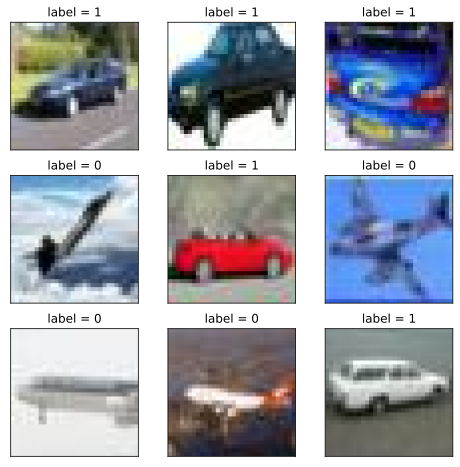

In [8]:
import matplotlib_inline
%config InlineBackend.figure_format = 'svg'

# 查看部分样本
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8)) # 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [10]:
for x, y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


# 定义模型

使用Keras接口有以下3种方式构建模型：使用 Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型

此处选择使用函数式API构建模型

In [13]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

# 训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也是最简单的内置fit方法

In [14]:
import datetime
import os


from pathlib import Path
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)


Epoch 1/10
100/100 [==============================] - 5s 42ms/step - loss: 0.4828 - accuracy: 0.7624 - val_loss: 0.3185 - val_accuracy: 0.8620
Epoch 2/10
100/100 [==============================] - 4s 40ms/step - loss: 0.3152 - accuracy: 0.8645 - val_loss: 0.2527 - val_accuracy: 0.8980
Epoch 3/10
100/100 [==============================] - 4s 43ms/step - loss: 0.2713 - accuracy: 0.8878 - val_loss: 0.2078 - val_accuracy: 0.9175
Epoch 4/10
100/100 [==============================] - 5s 46ms/step - loss: 0.2131 - accuracy: 0.9148 - val_loss: 0.2061 - val_accuracy: 0.9175
Epoch 5/10
100/100 [==============================] - 4s 44ms/step - loss: 0.1908 - accuracy: 0.9213 - val_loss: 0.1847 - val_accuracy: 0.9270
Epoch 6/10
100/100 [==============================] - 4s 45ms/step - loss: 0.1575 - accuracy: 0.9364 - val_loss: 0.1730 - val_accuracy: 0.9285
Epoch 7/10
100/100 [==============================] - 5s 54ms/step - loss: 0.1395 - accuracy: 0.9458 - val_loss: 0.1795 - val_accuracy: 0.9310

# 四，模型评估

In [18]:
%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
from tensorboard import notebook
notebook.list() 
#在tensorboard中查看模型
notebook.start("--logdir ./data/keras_model")

Known TensorBoard instances:
  - port 6006: logdir ./data/keras_model (started 0:01:19 ago; pid 123863)


Reusing TensorBoard on port 6006 (pid 123863), started 0:01:19 ago. (Use '!kill 123863' to kill it.)